<a href="https://colab.research.google.com/github/Insidiae/ztm-machine-learning/blob/main/7_deep_learning_neural_networks_tensorflow_2/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

> Identify the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from [Kaggle's dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/data).

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

For more info, check out the [Kaggle dog breed identification competition page](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).

## 4. Features

Some information about the data:

- We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
- There are 120 breeds of dogs (this means there are 120 different classes).
- There are around 10,000+ images in the training set (these images have labels).
- There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### 4.1. Getting our workspace ready

For this project, we'll be using [Google Colaboratory](https://colab.research.google.com/) to host our workspace.

Here's a basic checklist of what we need to set up:

- Import TensorFlow 2.x ✅

In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.6.0


- Import TensorFlow Hub ✅

In [2]:
import tensorflow_hub as hub
print("Hub version:", hub.__version__)

Hub version: 0.12.0


- Make sure we're using a GPU ✅

In [3]:
print("GPU:", "Available (YESSS!!!!!)" if tf.config.list_physical_devices("GPU") else "Not available...")

GPU: Available (YESSS!!!!!)


### 4.2. Getting data ready

We'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This project is hosted via Google Colaboratory. As such, one great way to setup our project data is to mount our Google Drive folder and import the data from there:

In [4]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We'll first have to unzip the files provided by Kaggle:

> **Note:** Running the cell below for the first time could take a while (a couple of minutes is normal). After you've run it once and got the data in your Google Drive, you don't need to run it again.

> **Note 2:** Wherever you see something like `drive/MyDrive/folderPath/` you will need to change it to wherever you are storing your files for this project. The first place you'll have to change it is the cell below:

In [5]:
# Use the '-d' parameter as the destination for where the files should go
# !unzip "drive/MyDrive/ZTM-MLCourse/dog-breed-identification.zip" -d "drive/MyDrive/ZTM-MLCourse/"

### 4.3. Accessing the data

Now that the data files we're working with are available on our Google Drive, we can start to check it out.

Let's start by accessing our data and checking out the labels:

In [6]:
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/ZTM-MLCourse/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,a7911b0e539a90bf79a9352161a37e68,scottish_deerhound
freq,1,126


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Looks like we've imported our labels correctly.

Looking at this, we can see there are 10222 different ID's (meaning 10222 different images) and 120 different breeds.

Let's see how many labeled images there are for each breed:

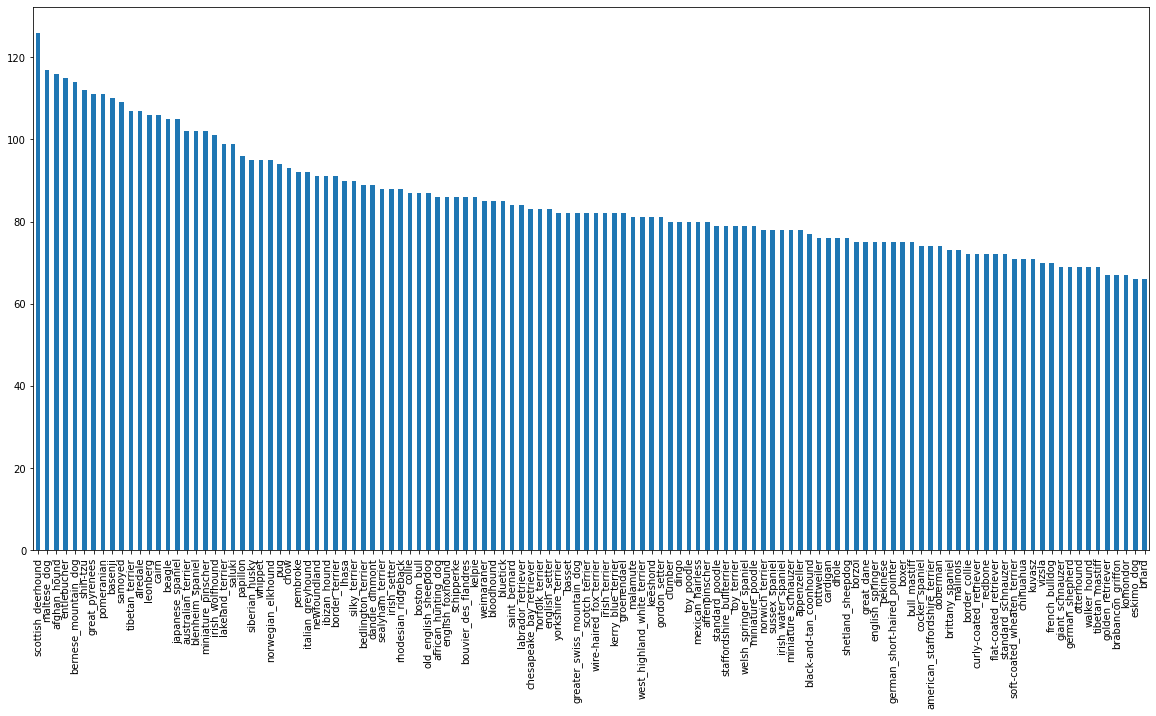

In [9]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

We can see that we get a pretty good distribution for the data. If we were to roughly draw a line across the middle of the graph, we'd see there's about 80+ images for each dog breed.

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's actually view one of the images:

> **Note:** Loading an image file for the first time may take a while as it gets loaded into the runtime memory. If you see a Google Drive timeout error, check out the [Colab FAQ](Note: Loading an image file for the first time may take a while as it gets loaded into the runtime memory. If you see a Google Drive timeout error, check out the Colab FAQ for more.) for more.

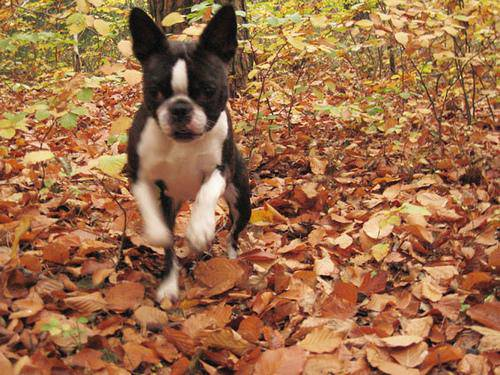

In [10]:
from IPython.display import display, Image
Image("drive/MyDrive/ZTM-MLCourse/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### 4.4. Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:

- A list a filepaths to training images
- An array of all labels
- An array of all unique labels

Importing all 10,000+ images at once will understandably take a long time. Instead, it's much more efficient to create a list of filepaths to the images to begin with:

In [11]:
filenames = ["drive/MyDrive/ZTM-MLCourse/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['drive/MyDrive/ZTM-MLCourse/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/ZTM-MLCourse/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

It's also a good idea to verify that we get the filenames correctly.

For starters, we can simply check if we get as many filenames as there are actual files in the `train` folder:

In [13]:
import os

if len(os.listdir("drive/MyDrive/ZTM-MLCourse/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


Let's also check if we can load an image from one of the items in our `filenames` list:

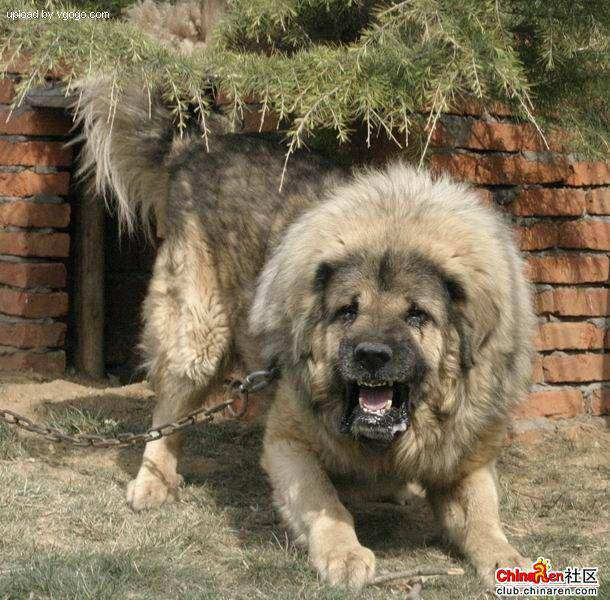

In [14]:
Image(filenames[9000])

Looking good!

Now that we've verified our image filepaths, let's get the labels.

We can take them from `labels_csv` and turn them into a NumPy array:

In [15]:
import numpy as np

labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

Let's also verify that we've got the correct amount of labels:

In [16]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


The description for the data we got from Kaggle says there should be 120 different breeds of dogs.

Let's check our `labels` and verify:

In [17]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

Our `labels` are currently in a string format. As such, we'll have to convert them into numbers before we can use them for our machine learning models to process.

To do so, we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`):

In [18]:
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

We can then do another list comprehension to iterate over the whole list of `labels`:

In [19]:
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

This is functionally the same as one-hot encoding our labels.

In this case, we've transformed a single dog breed name such as `boston_bull` into a one-hot array.

Let's see an example:

In [20]:
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### 4.5. Creating our own validation set

The data we got from Kaggle unfortunately does not include a validation set. However, we can easily make one ourselves.

We could use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`:

In [21]:
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

Remember, our goal when working through machine learning projects is to reduce the time between experiments. Loading all 10,000+ images at once will take longer than we want to when experimenting with our data.

Let's start experimenting with 1000 and increase it as we need.



In [22]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

Next, let's split our data into training and validation sets using `train_test_split()`:

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=420)

len(X_train), len(y_train), len(X_valid), len(y_valid)

(800, 800, 200, 200)

Let's check our training data:

In [26]:
X_train[:2], y_train[:2]

(['drive/MyDrive/ZTM-MLCourse/train/041a54577da744348d4da8094e882cd9.jpg',
  'drive/MyDrive/ZTM-MLCourse/train/1596cf0ab964b3ff0587f0d30042ca18.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,

### 4.6. Turn our images into Tensors

As with all machine learning models, our data has to be in numerical format.

Same goes with image data, so that's what we'll be doing first. We'll have to turn our images into *Tensors* (numerical representations), hence the *tensor* in Tensorflow.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape `(224, 224)`.
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images).

You might be wondering why we need a shape of `(224, 224)`, which is `(height, width)`. It's because this is the size of input our model (we'll see this soon) takes, an image which has the size of `(224, 224, 3)`.

The `(224, 224)` is the dimensions of the image, and the `3` at the end is the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete:

In [36]:
from matplotlib.pyplot import imread
image = imread(filenames[69]) # read in an image
image.shape

(375, 500, 3)

Notice the shape of `image`. The values `(375, 500, 3)` represent the height, width, and colour channel values respectively.

You can easily convert these values to a Tensor using [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant):

In [28]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Since we'll be doing these same steps for thousands of image samples, it would be a good idea to create a function to automate these conversions:

In [32]:
# Define image size
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[img_size, img_size])
  return image

Let's test this out on a single image:

In [35]:
process_image(filenames[69])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.44335870e-02, 1.83551554e-02, 3.20331287e-03],
        [1.37881711e-02, 1.77097414e-02, 3.38901114e-03],
        [2.08912752e-04, 4.13048174e-03, 0.00000000e+00],
        ...,
        [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
        [1.82860643e-02, 1.82860643e-02, 1.82860643e-02],
        [1.82860643e-02, 1.82860643e-02, 1.82860643e-02]],

       [[1.20994570e-02, 1.60210263e-02, 2.04762258e-03],
        [7.37413415e-04, 4.65898216e-03, 5.18573157e-04],
        [1.90108865e-02, 2.29324568e-02, 6.49486494e-04],
        ...,
        [1.21200671e-02, 1.21200671e-02, 1.21200671e-02],
        [1.17209386e-02, 1.17209386e-02, 1.17209386e-02],
        [1.17209386e-02, 1.17209386e-02, 1.17209386e-02]],

       [[1.10203698e-01, 1.08750619e-01, 8.79085362e-02],
        [1.20225839e-01, 1.18772753e-01, 9.79306623e-02],
        [1.13384195e-01, 1.11931115e-01, 9.10890251e-02],
        ...,
        [1.59022100e-02, 1.59022

### 4.7. Creating data batches

Now that we have a function to convert our images into Tensors, we'll also build one to turn our data into *batches* (more specifically, a TensorFlow [`BatchDataset`](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

A *batch* (also called *mini-batch*) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Since we're dealing with 10,000+ images, they will likely take more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of `(image, label)` Tensors, so we'll build a function to do create those first. We'll also take advantage of our `process_image` function along the way:

In [46]:
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of `(image, label)`.
  """
  image = process_image(image_path)
  return image, label

Let's test the function we just made:

In [47]:
get_image_label(X[69], y[69])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[1.44335870e-02, 1.83551554e-02, 3.20331287e-03],
         [1.37881711e-02, 1.77097414e-02, 3.38901114e-03],
         [2.08912752e-04, 4.13048174e-03, 0.00000000e+00],
         ...,
         [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
         [1.82860643e-02, 1.82860643e-02, 1.82860643e-02],
         [1.82860643e-02, 1.82860643e-02, 1.82860643e-02]],
 
        [[1.20994570e-02, 1.60210263e-02, 2.04762258e-03],
         [7.37413415e-04, 4.65898216e-03, 5.18573157e-04],
         [1.90108865e-02, 2.29324568e-02, 6.49486494e-04],
         ...,
         [1.21200671e-02, 1.21200671e-02, 1.21200671e-02],
         [1.17209386e-02, 1.17209386e-02, 1.17209386e-02],
         [1.17209386e-02, 1.17209386e-02, 1.17209386e-02]],
 
        [[1.10203698e-01, 1.08750619e-01, 8.79085362e-02],
         [1.20225839e-01, 1.18772753e-01, 9.79306623e-02],
         [1.13384195e-01, 1.11931115e-01, 9.10890251e-02],
         ...,
         [1

Next, we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann LeCun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [49]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, validation_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  # If the data if a valid dataset, we don't need to shuffle it
  elif validation_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  # If the data is a training dataset, we shuffle it
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
    return data_batch


Let's try to create some training and validation data batches:

In [51]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, validation_data=True)

Creating training data batches...
Creating validation data batches...


Let's check the data attributes of the data batches we just got:

In [52]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### 4.8 Visualizing data batches

Let's try to visualize the data batches we just got.

Using Matplotlib, we can create a function to show the images and their corresponding labels within the batch:


In [53]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  plt.figure(figsize=(10, 10))

  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors. So first, we need to unwind these batches into something that can be iterated over.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch. We can also pass this iterable output into the [`next()`](https://docs.python.org/3/library/functions.html#next) function to get the next item in the iterator, or in our case the next batch of 32 image and label pairs.

> **Note:** Running the cells below and loading images may take a little while.

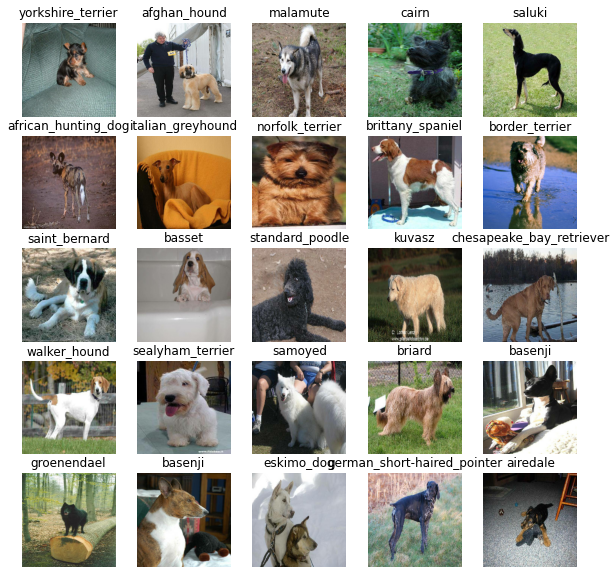

In [54]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

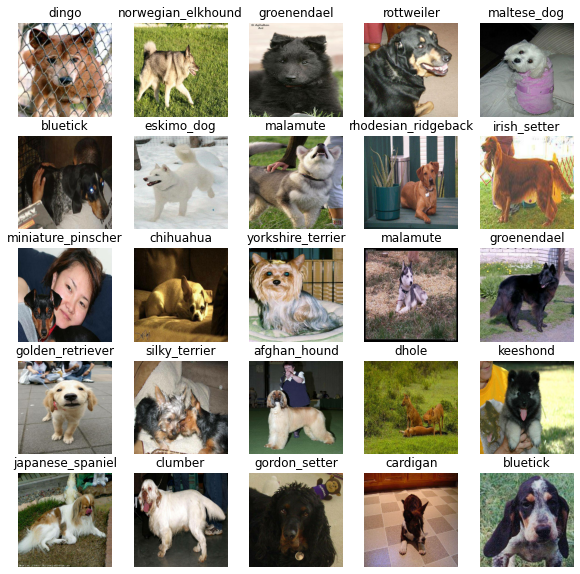

In [56]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images, valid_labels)

## 5. Modelling

For this project, we'll be using a pre-existing model from [TensorFlow Hub](https://tfhub.dev/). TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on. Using a pretrained machine learning model is often referred to as **transfer learning**.

**Why use a pretrained model?**

Building a machine learning model and training it on a lot of data from scratch can be expensive and time consuming.

Transfer learning helps alleviate some of these by taking what another model has learned and using that information with your own problem.

**How do we choose a model?**

Since we know our problem is image classification (classifying different dog breeds), we can navigate the TensorFlow Hub page by our problem domain (image).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, image classification.

Doing this gives a list of different pretrained models we can apply to our task. Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

### 5.1. Building a model

Before we build a model, there are a few things we need to define:

- The input shape (our images shape, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) of our model.
- The URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [57]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"